In [25]:
%reload_ext autoreload
%autoreload 2

from pncbf.train import (
    collect_ncbf,
    collect_qp,
    test_ncbf,
    test_qp,
    train_ncbf,
    train_qp,
)
from pncbf.config import Arguments
from pncbf.filter import NullFilter, HandmadeFilter

import numpy as np
import random
import torch

args = Arguments()
args.random_seed = 42
args.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random.seed(args.random_seed)
np.random.seed(args.random_seed)
torch.manual_seed(args.random_seed)
np.set_printoptions(precision=2, suppress=True)

In [26]:
args.max_agent_vel = 2
args.world_dims = [0, 100]
args.rollouts = 100
args.steps_per_rollout = 50
args.filter = NullFilter # nominal filter
args.render = False
    
rollout_data = collect_ncbf(args)

In [27]:
args.num_epochs = 100
args.learning_rate = 1e-4
args.hidden_dims = [256, 128, 64, 32]

ncbf_model = train_ncbf(args, rollout_data)

[100/100] | Loss: 0.0119: 100%|██████████| 100/100 [00:00<00:00, 266.42it/s]


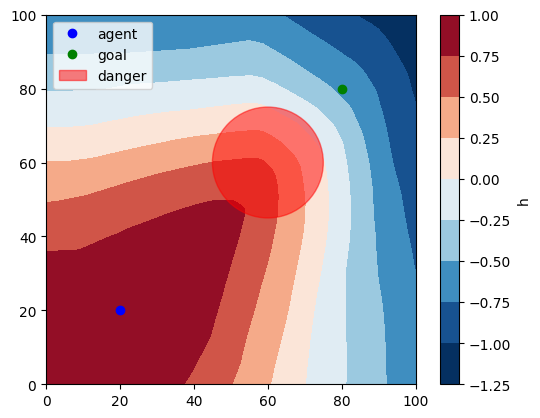

In [28]:
args.contour_grid_size = 100
args.contour_levels = 8

test_ncbf(args, ncbf_model)

In [29]:
args.rollouts = 200
args.steps_per_rollout = 50
args.filter = HandmadeFilter
args.render = False

qp_data = collect_qp(args, ncbf_model)

In [30]:
args.num_epochs = 2000
args.learning_rate = 1e-4
args.hidden_dims = [256, 128, 64, 32]

qp_model = train_qp(args, qp_data)

  0%|          | 0/2000 [00:00<?, ?it/s]

[2000/2000] | Loss: 0.0019: 100%|██████████| 2000/2000 [00:07<00:00, 270.26it/s]


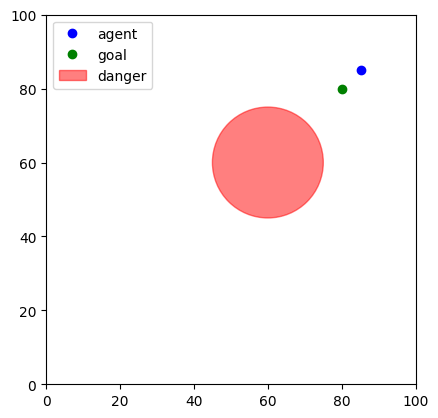

State array:
[85.28 85.14  0.01 -0.01 80.   80.    0.    0.   60.   60.    0.    0.  ]
h: -0.6992
action: [ 0.01 -0.01]


In [31]:
args.rollouts = 5
args.steps_per_rollout = 75

_ = test_qp(args, qp_model)